In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import time
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
import torch.optim as optimizers

import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torchtext
from torchtext.data import get_tokenizer
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
#set random seed
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
set_seed(123)

In [3]:
# Easy data augmentation techniques for text classification
# Jason Wei and Kai Zou

import random
from random import shuffle


#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1
	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	#sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	#ri
	for _ in range(num_new_per_technique):
		a_words = random_insertion(words, n_ri)
		augmented_sentences.append(' '.join(a_words))

	#rs
	for _ in range(num_new_per_technique):
		a_words = random_swap(words, n_rs)
		augmented_sentences.append(' '.join(a_words))

	#rd
	for _ in range(num_new_per_technique):
		a_words = random_deletion(words, p_rd)
		augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

In [4]:
def expand_dataset(df, num_aug):
    aug_dict = {"id": [],
                "description": [],
               "jobflag": []}
    
    # weight to balance amount of data
    weight = [len(df[df.jobflag==n+1]) for n in range(len(df.jobflag.unique()))]
    
    for idx in tqdm(range(len(df))):
        
        if num_aug == 8:
            alpha_sr=0.05
            alpha_ri=0.05
            alpha_rs=0.05
            p_rd=0.05
        
        else:
            num_aug = 4
            alpha_sr=0.1
            alpha_ri=0.1
            alpha_rs=0.1
            p_rd=0.1
        
        # weight to balance the amount of labels
        if df.jobflag.iloc[idx] == 1:
            num_aug = int(num_aug*weight[2-1]/weight[1-1])
        elif df.jobflag.iloc[idx] == 2:
            # standard
            num_aug = num_aug
        elif df.jobflag.iloc[idx] == 3:
            num_aug = int(num_aug*weight[2-1]/weight[3-1])
        elif df.jobflag.iloc[idx] == 4:
            num_aug = int(num_aug*weight[2-1]/weight[4-1])
            
            
        #Augmentation 
        aug = eda(df.description.iloc[idx], alpha_sr=alpha_sr, alpha_ri=alpha_ri, alpha_rs=alpha_rs, p_rd=p_rd, num_aug=num_aug)
        job = df.jobflag.iloc[idx]
        ids = df.id.iloc[idx]
        for n in range(len(aug)):
            aug_dict["id"].append(ids)
            aug_dict["description"].append(aug[n])
            aug_dict["jobflag"].append(job)
       
    print('now augmentation compleet !!')
            
    aug_df = pd.DataFrame(aug_dict)
    return aug_df

In [5]:
#read data_files
train = pd.read_csv('../input/signate-stcup-2020/train.csv')
test = pd.read_csv('../input/signate-stcup2020-new/test.csv')

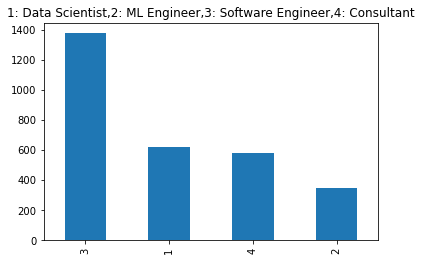

In [6]:
#visualize the data
plt.figure()
plt.title("1: Data Scientist,2: ML Engineer,3: Software Engineer,4: Consultant")
train.jobflag.value_counts().plot(kind="bar")

In [7]:

"""
https://github.com/allenai/dont-stop-pretraining/blob/master/mlm_study/huggingface_study/mlm.py
"""
from typing import Tuple, List
from transformers import  AutoModelWithLMHead, AutoTokenizer, PreTrainedTokenizer
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

def mask_tokens(inputs, tokenizer, mlm_probability=0.15):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """
    
    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]

    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)
    
    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [8]:
#define dataset
class TAPT_Dataset(Dataset):
    def __init__(self, csv_file, model_type):
        self.csv_file = csv_file
        
        if model_type == "BERT":
            from transformers import BertTokenizer
            self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
            
        elif model_type == "ALBERT":
            from transformers import AlbertTokenizer
            self.tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
            
        elif model_type == "XLNET":
            from transformers import XLNetTokenizer
            self.tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
        
        elif model_type == "ROBERTA":
            from transformers import RobertaTokenizer
            self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
            
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        
        inputs = self.csv_file.description.iloc[idx]
        inputs = self.tokenizer.encode_plus(inputs, max_length=128, 
                                           pad_to_max_length = True,
                                           return_attention_mask = False,
                                           return_token_type_ids=False,)
        inputs = torch.tensor(inputs['input_ids'])
        
        return inputs

In [9]:
def model_config(csv_file, model_type, num_workers):
    tapt_dataset = TAPT_Dataset(csv_file=csv_file, model_type=model_type)

    tapt_dataloader = DataLoader(tapt_dataset, batch_size=batch_size, shuffle=True,
                                        num_workers=num_workers, pin_memory=True, drop_last=True)
    
    model = MLM_Net(model_type=model_type)
    
    return tapt_dataloader, model

In [10]:
#define BERT based model
class MLM_Net(nn.Module):
    def __init__(self, model_type):
        super().__init__()
        
        if model_type == "ALBERT":
            from transformers import AlbertTokenizer, AlbertForMaskedLM
            self.model_ = AlbertForMaskedLM.from_pretrained(
                "albert-large-v2",early_stopping=True)
            
        elif model_type == "BERT":
            from transformers import BertTokenizer, BertForMaskedLM
            self.model_ = BertForMaskedLM.from_pretrained(
                "bert-base-cased",early_stopping=True)
            
        elif model_type == "XLNET":
            from transformers import XLNetTokenizer, XLNetForMaskedLM
            self.model_ = XLNetForMaskedLM.from_pretrained(
                "xlnet-base-cased",early_stopping=True)
            
        elif model_type == "ROBERTA":
            from transformers import RobertaTokenizer, RobertaForMaskedLM
            self.model_ = RobertaForMaskedLM.from_pretrained(
                "roberta-base",early_stopping=True)
            
        for param in self.model_.parameters():
            param.requires_grad = True
        
    def forward(self, x, t):
        """
        inputs = self.model_.prepare_inputs_for_generation(input_ids=x)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        """
        try:
            outputs = self.model_(input_ids=x, attention_mask=None, lm_labels=t)
        except:
            outputs = self.model_(input_ids=x, attention_mask=None, labels=t)
            
        loss, prediction_scores = outputs[:2]
        
        #del inputs, ids, mask, x
        return loss, prediction_scores
    
    def save_(self, DIR):
        self.model_.save_pretrained(DIR)

In [11]:
#train utils
def train_step(x, t, model, optimizer):
    #preds = model(x)
    #loss = compute_loss(t, preds)
    #accuracy = compute_accuracy(torch.argmax(t,dim=1), torch.argmax(preds,dim=1))
    loss, preds = model(x, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    return loss, preds

def val_step(x, model, optimizer):
    #preds = model(x)
    #loss = compute_loss(t, preds)
    #accuracy = compute_accuracy(torch.argmax(t,dim=1), torch.argmax(preds,dim=1))
    loss, preds = model(x)
    return loss, preds


#define EarlyStopping
class EarlyStopping:
    def __init__(self, patience=0, verbose=0, score_type="loss"):
        self._step = 0
        self.score_type = score_type
        if score_type == "loss":
            self._score = float('inf')
        elif score_type == "acc":
            self._score = -float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss, acc, epoch, model_dict, optim_dict, PATH):
        score = loss if self.score_type=="loss" else acc
        if self.score_check(score):
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._score = score
            torch.save({
            'epoch': epoch,
            'model_state_dict': model_dict,
            'optimizer_state_dict': optim_dict,
            'loss': loss,
            "accuracy": acc,
            }, PATH)
            print('Save check_point for "{}"'.format(PATH))
    
    def score_check(self,score):
        if self.score_type == "loss":
            if self._score < score:
                return True
            else:
                return False
        elif self.score_type == "acc":
            if self._score > score:
                return True
            else:
                return False

        return False

# define HistoryRecorder
class HistoryRecorder:
    def __init__(self, hist_type=2):
        self.hist_type = hist_type
        
        if self.hist_type ==1:
            self.hist = {'loss': [], 'val_loss': []}
        elif self.hist_type == 2:
            self.hist = {'loss': [], 'val_loss': [], "acc": [], "val_acc": []}
        elif self.hist_type == 3:
            self.hist = {"loss": [], "acc": []}
        
    def record(self, loss, val_loss=None, 
              acc=None, val_acc=None):
        
        if self.hist_type == 1 or 2:
            self.hist["loss"].append(loss)
            self.hist["val_loss"].append(val_loss)
            if self.hist_type == 2:
                self.hist["acc"].append(acc)
                self.hist["val_acc"].append(val_acc)
                
        elif self.hist_type == 3:
            self.hist["loss"].append(loss)
            self.hist["acc"].append(acc)
        
    def hist(self):
        return self.hist

    
# visualizing function
def show_hist(loss=None, val_loss=None, acc=None, val_acc=None,
              hist=None, loss_type=None, acc_type=None):   
    if hist:
        loss = hist['loss']
        val_loss = hist['val_loss']
        acc = hist["acc"]
        val_acc = hist["val_acc"]
    
    plt.figure(figsize=(10,12))
    #visualize loss
    plt.subplot(2,1,1)
    plt.rc('font', family='serif')
    plt.plot(range(len(loss)), loss,
             color='blue', linewidth=1,
             label='train_loss')
    plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss (type = {})'.format(loss_type if loss_type else "None"))
    plt.legend()
    
    #visualize accurauy
    plt.subplot(2,1,2)
    plt.rc('font', family='serif')
    plt.plot(range(len(acc)), acc,
             color='blue', linewidth=1,
             label='train_acc')
    plt.plot(range(len(val_acc)), val_acc,
             color='red', linewidth=1,
             label='val_acc')
    plt.xlabel('epochs')
    plt.ylabel('accuracy (type = {})'.format(acc_type if acc_type else "None"))
    plt.legend()
    
    plt.show()

In [12]:
def RUN_TAPT(train_dataloader, tokenizer, model, optimizer, epochs=10):
    #training phase
    if __name__ == '__main__':

        #es = EarlyStopping(patience=patience, verbose=1, score_type="loss")
        hist = HistoryRecorder(hist_type=2)

        model.to(device)
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.
            train_acc = 0.
            val_acc = 0.

            model.train()#####training phase#####
            for x in tqdm(train_dataloader):
                x, t = mask_tokens(inputs=x, tokenizer=tokenizer)
                x, t = x.to(device), t.to(device)
                #x = x.to(device)
                loss, preds = train_step(x, t, model, optimizer)
                train_loss += loss.detach().item()
                #train_acc += accuracy.to('cpu')
            train_loss /= len(train_dataloader)
            train_acc /= len(train_dataloader)

            hist.record(train_loss,val_loss,train_acc,val_acc)
            print('epoch: {}, train_loss: {:.3}, train_acc:{:.3}'.format(
                    epoch+1, train_loss, train_acc))
            
            
        model.save_("./")
        ## visualize train_loss and val_loss ##
        show_hist(hist=hist.hist, loss_type="LM_loss", acc_type="prediction_score")

In [13]:
def main(csv_files, csv_files_2, model_type, num_aug, max_len, batch_size, num_workers, epochs):
    # 
    if model_type == "BERT":
        from transformers import BertTokenizer
        tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
            
    elif model_type == "ALBERT":
        from transformers import AlbertTokenizer
        tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
            
    elif model_type == "XLNET":
        from transformers import XlnetTokenizer
        tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
        
    elif model_type == "ROBERTA":
        from transformers import RobertaTokenizer
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # concat data files
    csv_file = pd.DataFrame([])
    for file in csv_files:
        file = pd.read_csv(file)
        csv_file = pd.concat([csv_file, file])
    
    print(f'the amount of data is {len(csv_file)}')
    
    # DataAugmentation
    if num_aug:
        print('now augmentation...')
        csv_file = expand_dataset(csv_file, num_aug)
        
    # define dataloader and optimizer
    tapt_dataloader, model = model_config(csv_file, num_workers=num_workers, model_type=model_type)
    optimizer = AdamW(model.parameters(), lr=1e-5)
    
    # run
    RUN_TAPT(train_dataloader=tapt_dataloader,
             tokenizer=tokenizer,
             epochs=epochs, model=model, 
             optimizer=optimizer)
    
    
    ## 2周目 ##
    # config
    csv_files = csv_files_2
    epochs *= 8
    num_aug = None
    
    # concat data files
    csv_file = pd.DataFrame([])
    for file in csv_files:
        file = pd.read_csv(file)
        csv_file = pd.concat([csv_file, file])
    
    print(f'the amount of data is {len(csv_file)}')

    # DataAugmentation
    if num_aug:
        print('now augmentation...')
        csv_file = expand_dataset(csv_file, num_aug)
        
    # define dataloader and optimizer
    tapt_dataloader, _ = model_config(csv_file, num_workers=num_workers, model_type=model_type)
    
    RUN_TAPT(train_dataloader=tapt_dataloader,
             tokenizer=tokenizer,
             epochs=epochs, model=model, 
             optimizer=optimizer)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
##### training configuration #####
csv_files = ["../input/augmented-train-test/stcup2020-test-google-ar-all.csv",
            "../input/augmented-train-test/stcup2020-test-google-bg-all.csv",
            "../input/augmented-train-test/stcup2020-test-google-de-all.csv",
            "../input/augmented-train-test/stcup2020-test-google-el-all.csv",
            "../input/augmented-train-test/stcup2020-test-google-es-all.csv",
            "../input/augmented-train-test/stcup2020-test-google-hi-all.csv",
            "../input/augmented-train-test/stcup2020-test-google-sw-all.csv",
            "../input/augmented-train-test/stcup2020-test-google-vi-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-ar-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-bg-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-de-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-el-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-es-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-hi-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-sw-all.csv",
            "../input/augmented-train-test/stcup2020-train-google-vi-all.csv",
            "../input/signate-stcup-2020/train.csv", 
            "../input/signate-stcup2020-new/test.csv"
            ]

csv_files_2 = ["../input/signate-stcup-2020/train.csv",
            "../input/signate-stcup2020-new/test.csv"]

# augmentation type => 4 or 8, or None
num_aug = None

#training model => ["BERT", "ALBERT", "XLNET", "ROBERTA"]
model_type = "BERT"
version = 3 # version will used for PATH{="model_type" + "_v" + str(version) + "x-folds"(n_folds > 1)}
                # example: "ALBERT_v1_0", "XLNET_v4_4"
max_len = 128

###
batch_size = 32
num_workers = 4
epochs = 5


the amount of data is 42066


  0%|          | 0/1314 [00:00<?, ?it/s]

epoch: 1, train_loss: 3.68, train_acc:0.0


  0%|          | 0/1314 [00:00<?, ?it/s]

epoch: 2, train_loss: 2.8, train_acc:0.0


  0%|          | 0/1314 [00:00<?, ?it/s]

epoch: 3, train_loss: 2.55, train_acc:0.0


  0%|          | 0/1314 [00:00<?, ?it/s]

epoch: 4, train_loss: 2.37, train_acc:0.0


100%|██████████| 1314/1314 [10:47<00:00,  2.03it/s]


epoch: 5, train_loss: 2.27, train_acc:0.0


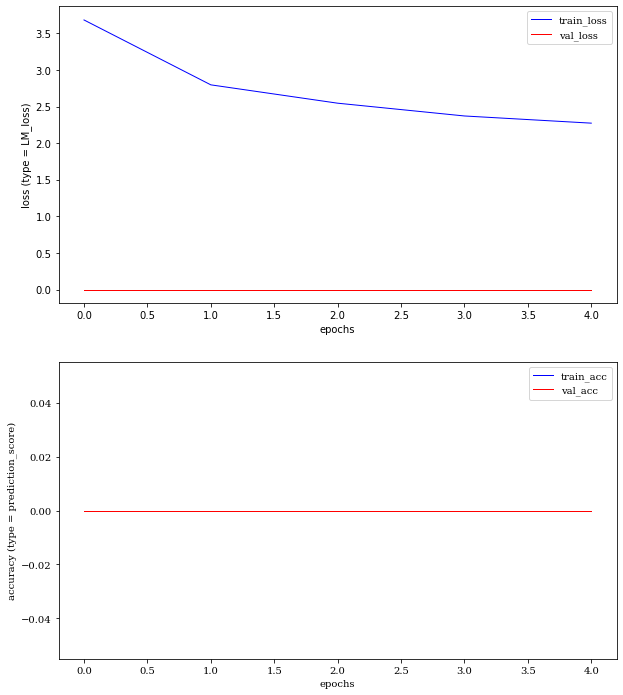

the amount of data is 4674


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 1, train_loss: 2.38, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 2, train_loss: 2.35, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 3, train_loss: 2.27, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 4, train_loss: 2.25, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 5, train_loss: 2.2, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 6, train_loss: 2.21, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 7, train_loss: 2.17, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 8, train_loss: 2.16, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 9, train_loss: 2.14, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 10, train_loss: 2.13, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 11, train_loss: 2.13, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 12, train_loss: 2.07, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 13, train_loss: 2.06, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 14, train_loss: 2.03, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 15, train_loss: 2.01, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 16, train_loss: 2.0, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 17, train_loss: 2.01, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 18, train_loss: 2.02, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 19, train_loss: 1.93, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 20, train_loss: 1.95, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 21, train_loss: 1.92, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 22, train_loss: 1.86, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 23, train_loss: 1.92, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 24, train_loss: 1.89, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 25, train_loss: 1.91, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 26, train_loss: 1.84, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 27, train_loss: 1.85, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 28, train_loss: 1.84, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 29, train_loss: 1.79, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 30, train_loss: 1.8, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 31, train_loss: 1.78, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 32, train_loss: 1.75, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 33, train_loss: 1.75, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 34, train_loss: 1.73, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 35, train_loss: 1.72, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 36, train_loss: 1.65, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 37, train_loss: 1.68, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 38, train_loss: 1.73, train_acc:0.0


  0%|          | 0/146 [00:00<?, ?it/s]

epoch: 39, train_loss: 1.66, train_acc:0.0


100%|██████████| 146/146 [01:11<00:00,  2.03it/s]


epoch: 40, train_loss: 1.64, train_acc:0.0


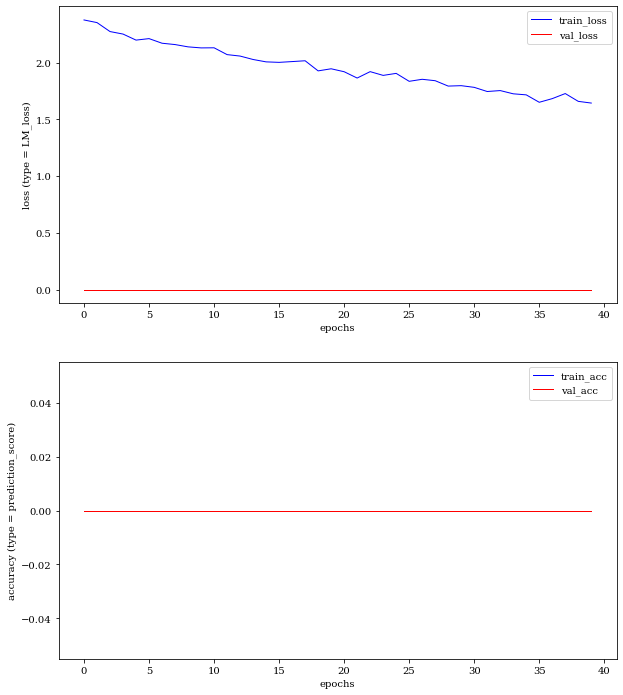

In [16]:

main(csv_files=csv_files, csv_files_2=csv_files_2, 
     model_type=model_type, num_aug=num_aug, 
     max_len=max_len, batch_size=batch_size, 
     epochs=epochs, num_workers=num_workers)
